In [1]:
import os
import sys
import logging
import pickle
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from warnings import filterwarnings
filterwarnings('ignore')

from minio import Minio

# settings
MINIO_HOST = os.environ.get('MINIO_HOST', '')
MINIO_ACCESS_KEY = os.environ.get('MINIO_ACCESS_KEY', '')
MINIO_SECRET_KEY = os.environ.get('MINIO_SECRET_KEY', '')

os.environ['MLFLOW_TRACKING_URI'] = ""
os.environ['MLFLOW_S3_ENDPOINT_URL'] = ""
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
log = logging.getLogger(__name__)

In [3]:
# https://colab.research.google.com/drive/1SGsU5jyuJVodUwAhf3Budeyh7c-gHXOR?usp=sharing

### Notes
### SHIP 2 Dataset:: # missing columns from ship1 (this ship 1 has all columns included) 'Ship_SpeedLOG'
### SHIP 3 Dataset:: # missing columns from ship1 'Ship_SpeedLOG', 'ship_speed_actual'

In [4]:
class DataLoader(object):
    def __init__(self):
        self.random_state = 42
        self.bucket = 'uploads'
        self.directory = 'data'
        
        self.date_col = ['measurement_time']
        
        self.numerical_columns = [
             'cyl_chargeair_press', 'AE_FO_inlet_flow',
             'draught_aft_side', 'AE_FO_inlet_Temp',
             'engine_speed','DG_1_power',
             'DG_2_power','DG_4_power',
             'CAC_CW_HT_pressure', 'CAC_in_Low_Temperature_CW_temp',
             'propeller_shaft_output', 'propeller_shaft_rpm',
             'propeller_shaft_thrust', 'cyl_chargeair_temp', 
             'cyl_exh_gas_temp_mean','torque',
             'AE_FO_outlet_flow', 'AE_FO_outlet_Temp',
             'Eng_in_HTCW_press', 'Eng_in_Jacket_HTCW_temp',
             'Eng_out_Jacket_HTCW_temp', 'Eng_Relative_load',
             'FO_Rack_position', 'FO_inlet_press',
             'fueloil_inlet_temperature', 'ME_FO_inlet_flow',
             'ME_FO_outlet_Temp', 'ME_FO_outlet_flow',
             'LO_Filter_P', 'LO_filter_in_press',
             'LO_in_press', 'LO_in_temp',
             'LO_out_temp_TC', 'LO_cooler_CW_out_temp'
        ]
        self.categorical_columns = [
            'DG_1_condition','DG_2_condition',
            'DG_3_condition','DG_4_condition',
            'ship_inclination'
        ]
        self.monitoring_col_name = 'ME_FO_consumption'
        self.monitoring_col = [self.monitoring_col_name]
        
        self.columns_used = self.date_col + self.numerical_columns + self.categorical_columns + self.monitoring_col
        self.for_normalization_cols = self.numerical_columns
        
        
    
    def load_dataset_(self, ship_id):
        client = Minio(
            MINIO_HOST,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=False
        )
        data_path = f'{self.directory}/{ship_id}.csv'
        obj = client.get_object(self.bucket, data_path)
        df = pd.read_csv(obj, parse_dates=self.date_col, usecols=self.columns_used)
        return df
    
    def _data_preparation(self,
                          df,
                          resampling='10min'
                         ):
        df = df.dropna()
        df = df.loc[:, (df != df.iloc[0]).any()]
        df = df.set_index('measurement_time')
        resampled_df = df.resample(resampling).sum()
        return resampled_df    

In [5]:
class LSTMModel(object):
    def __init__(self):
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        self.data_size = 4000
        self.lag = 10
    
    def _store_scalers(self,
                       scaler_x_path='lstm_vessel2_x_scaler.pkl',
                       scaler_y_path='lstm_vessel2_y_scaler.pkl'
                      ):
        pickle.dump(self.x_scaler, open(scaler_x_path, 'wb'))
        pickle.dump(self.y_scaler, open(scaler_y_path, 'wb'))
        
    def _data_processing(self,
                         resampled_data,
                         num_of_features,
                         sample_size
                        ):
        test_data_size = sample_size - self.data_size
        
        train_data = resampled_data.iloc[:self.data_size, :]
        test_data = resampled_data.iloc[self.data_size:, :]
        
        train_data_scaled = self.x_scaler.fit_transform(train_data)
        train_data_scaled_y = self.y_scaler.fit_transform(train_data[['ME_FO_consumption']])
        
        test_data_scaled = self.x_scaler.transform(test_data)
        test_data_scaled_y = self.y_scaler.transform(test_data[['ME_FO_consumption']])
        
        self._store_scalers()
        
        return train_data_scaled, train_data_scaled_y, test_data_scaled, test_data_scaled_y
    
    def _set_sliding_window(
        self,
        data_x,
        data_y,
        size
    ):
        X_list = []
        Y_list = []
        for i in range(self.lag, size):
            sequence = data_x[i-self.lag:i]
            target = data_y[i,0]
            X_list.append(sequence)
            Y_list.append(target)
            X_arr = np.array(X_list)
            Y_arr = np.array(Y_list)
        return X_arr, Y_arr
        
    
    def _model_builder_(self, num_of_features):
        lstm_model = Sequential()
        lstm_model.add(LSTM(40, activation="tanh", return_sequences=True, input_shape=(self.lag, num_of_features)))
        lstm_model.add(Dropout(0.15))
        lstm_model.add(LSTM(40, activation="tanh", return_sequences=True))
        lstm_model.add(Dropout(0.15))
        lstm_model.add(LSTM(40, activation="tanh", return_sequences=False))
        lstm_model.add(Dropout(0.15))
        lstm_model.add(Dense(1))
        lstm_model.summary()
        return lstm_model
    
    def _fit(self,
             lstm_model,
             X_train,
             Y_train,
             X_test,
             Y_test,
             epochs=10,
             batch_size=100
            ):
        lstm_model.compile(optimizer='adam', loss='MSE')
        early_stop = EarlyStopping(monitor='val_loss', patience=2)
        lstm_model.fit(
            X_train,
            Y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, Y_test), callbacks=[early_stop]
        )
        return lstm_model

    
    def _gen_metrics(self, true_value, predicted):
        
        mae = mean_absolute_error(true_value, predicted)
        mse = mean_squared_error(true_value, predicted)
        r2 = r2_score(true_value, predicted)
        
        log.info(f'ANN MAE: {mae}')
        log.info(f'ANN MSE: {mse}')
        log.info(f'ANN R2: {r2}')
        metrics_dict = {
            'mae': mae,
            'mse': mse,
            'r2': r2
        }
        return metrics_dict
    
    @staticmethod
    def plot_predictions(test, predicted, title='Predictions made by LSTM Model'):
        fig = plt.figure(figsize=(16,4))
        plt.plot(test, color='blue',label='Actual ME Fuel Consumption')
        plt.plot(predicted, alpha=0.7, color='orange',label='Predicted ME Fuel Consumption')
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Normalized ME Fuel Consumption Scale')
        plt.legend()
        plt.show()
        return fig

In [6]:
class ArtifactStorage(object):
    def __init__(self,
                 experiment_name,
                 model,
                 model_name,
                 metrics_dict
                ):
        self.experiment_name = experiment_name
        self.model_name = model_name
        self.model = model
        self.metrics_dict = metrics_dict
        
    def _log_to_mlflow(self,
                       fig,
                       figure_name='LSTM_ACTUAL_VS_PREDICTED_FO_CONS_VESSEL2.png',
                       scaler_x_path='lstm_vessel2_x_scaler.pkl',
                       scaler_y_path='lstm_vessel2_y_scaler.pkl'
                      ):
        mlflow.set_experiment(self.experiment_name)
        with mlflow.start_run():
            
            mlflow.log_artifact(scaler_x_path)
            mlflow.log_artifact(scaler_y_path)
            mlflow.log_figure(fig, figure_name)
            
            mlflow.keras.log_model(
                self.model,
                self.model_name,
                registered_model_name=self.model_name
            )
            
            for metrics_tuple in self.metrics_dict.items():
                mlflow.log_metric(metrics_tuple[0], metrics_tuple[1])

In [7]:
data_loader = DataLoader()
data = data_loader.load_dataset_(ship_id='ship_2')

Text(0.5, 1.0, 'Vessel ME Fuel Consumption - BEFORE NORMALIZATION')

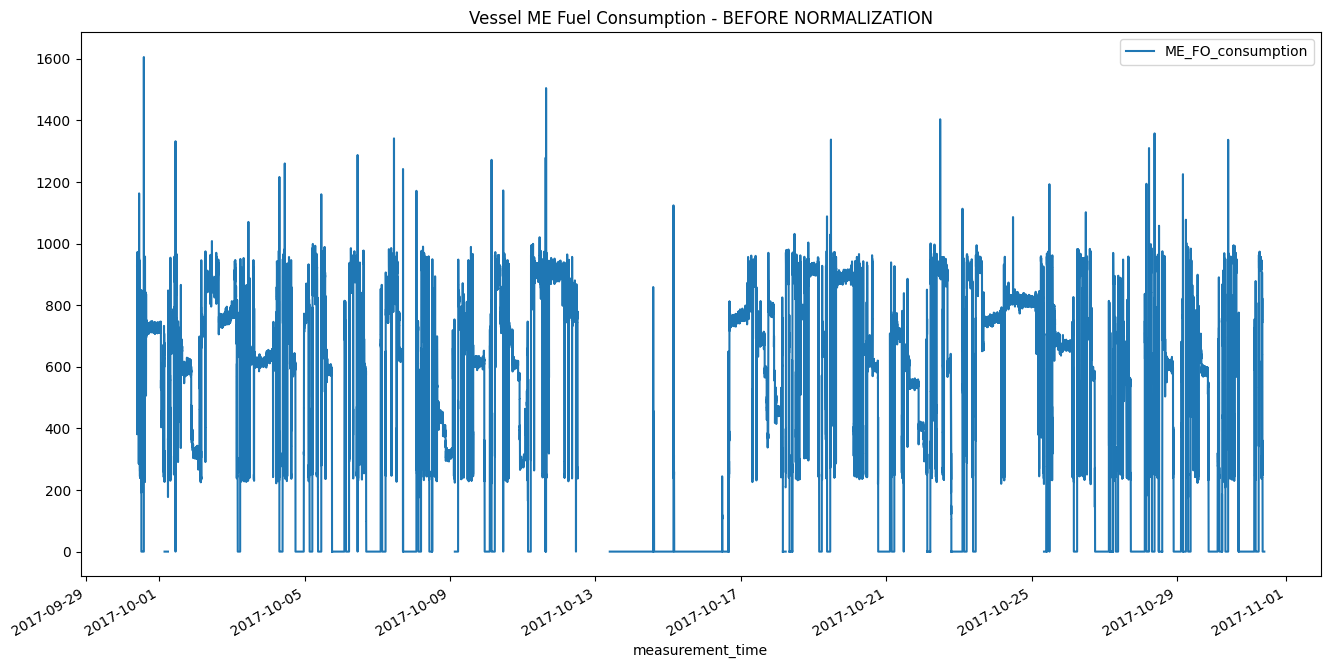

In [8]:
data.plot('measurement_time', 'ME_FO_consumption', figsize=(16,8), legend=True)
plt.title('Vessel ME Fuel Consumption - BEFORE NORMALIZATION')

In [9]:
resampled = data_loader._data_preparation(data)

Text(0.5, 1.0, 'Vessel ME Fuel Consumption - BEFORE NORMALIZATION - 10 minute resampling')

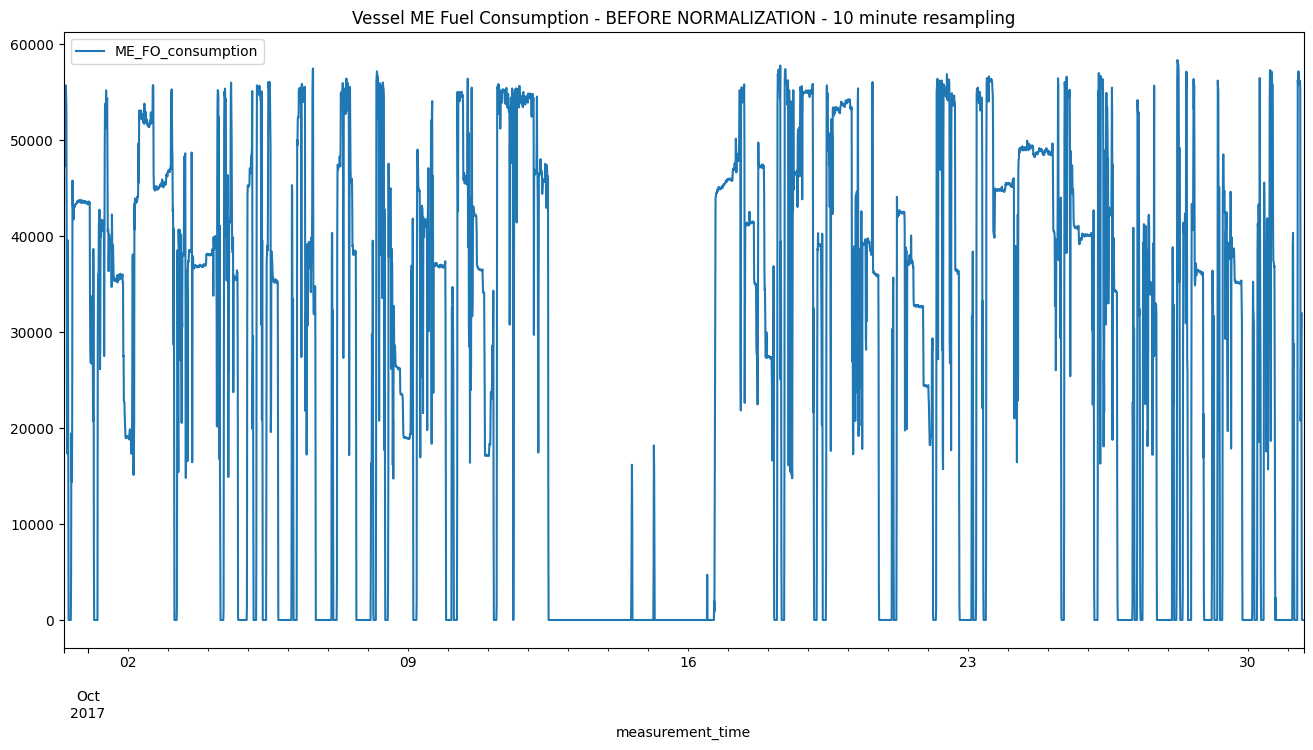

In [10]:
resampled.plot(y='ME_FO_consumption', use_index=True, figsize=(16,8), legend=True)
plt.title('Vessel ME Fuel Consumption - BEFORE NORMALIZATION - 10 minute resampling')

In [12]:
lstm_obj = LSTMModel()
train_data_scaled, train_data_scaled_y, test_data_scaled, test_data_scaled_y = lstm_obj._data_processing(
    resampled_data=resampled,
    num_of_features=resampled.shape[1],
    sample_size=resampled.shape[0]
)

In [13]:
vessel2_data_size = resampled.shape[0]
num_of_features = resampled.shape[1]
train_data_size = 4000

X_train, Y_train = lstm_obj._set_sliding_window(size=train_data_size, data_x=train_data_scaled, data_y=train_data_scaled_y)
X_test, Y_test = lstm_obj._set_sliding_window(
    size=(vessel2_data_size-train_data_size),
    data_x=test_data_scaled,
    data_y=test_data_scaled_y
)

In [24]:
model_init = lstm_obj._model_builder_(num_of_features=num_of_features)
trained_model = lstm_obj._fit(
    lstm_model=model_init,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    epochs=30
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 40)            12960     
                                                                 
 dropout_6 (Dropout)         (None, 10, 40)            0         
                                                                 
 lstm_7 (LSTM)               (None, 10, 40)            12960     
                                                                 
 dropout_7 (Dropout)         (None, 10, 40)            0         
                                                                 
 lstm_8 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [25]:
lstm_predictions = trained_model.predict(X_test)

15/15 [==============================] - 2s 6ms/step


In [26]:
lstm_metrics_dict = lstm_obj._gen_metrics(Y_test, lstm_predictions)

2022-12-02 14:03:02,331 - __main__ - INFO - ANN MAE: 0.07928109425752662
2022-12-02 14:03:02,332 - __main__ - INFO - ANN MSE: 0.015180558880218705
2022-12-02 14:03:02,333 - __main__ - INFO - ANN R2: 0.877614692921883


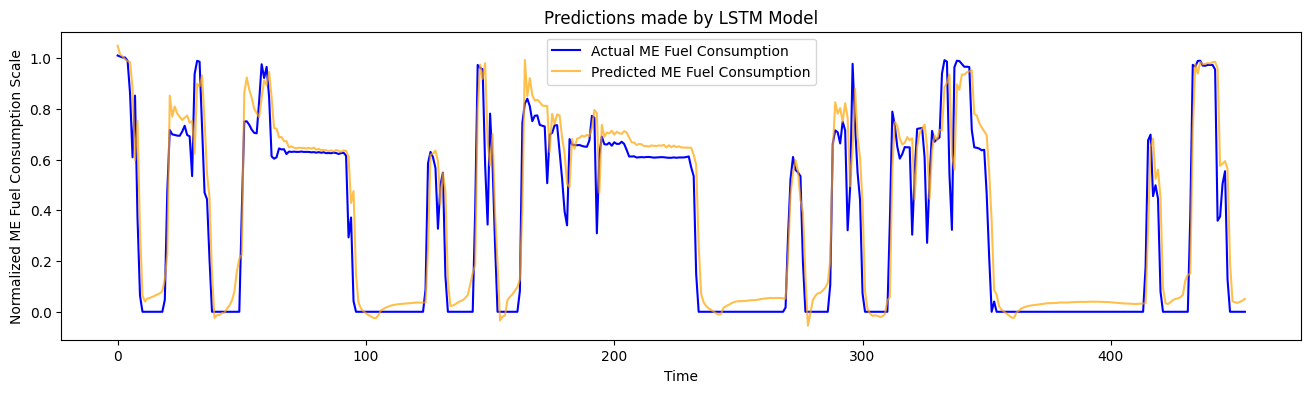

In [27]:
fig = lstm_obj.plot_predictions(Y_test, lstm_predictions)

In [23]:
experiment_name = 'MEFuelConsumptionLSTM_VESSEL2'
model = trained_model
model_name = 'lstm_vessel2'
metrics_dict = lstm_metrics_dict
as_obj = ArtifactStorage(experiment_name=experiment_name, model=model, model_name=model_name, metrics_dict=metrics_dict)
as_obj._log_to_mlflow(fig=fig)

2022-12-02 14:01:57,930 - absl - WARNING - Found untraced functions such as _update_step_xla, lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_fn, lstm_cell_4_layer_call_and_return_conditional_losses while saving (showing 5 of 7). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: C:\Users\PKAPSA~1.EPU\AppData\Local\Temp\tmpjytdit94\model\data\model\assets
2022-12-02 14:01:59,166 - tensorflow - INFO - Assets written to: C:\Users\PKAPSA~1.EPU\AppData\Local\Temp\tmpjytdit94\model\data\model\assets


Registered model 'lstm_vessel2' already exists. Creating a new version of this model...
2022/12/02 14:02:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lstm_vessel2, version 2
Created version '2' of model 'lstm_vessel2'.
